In [1]:
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import ndimage

import sys
import os
from PIL import Image
from glob import glob
import h5py
import time

In [115]:
data_dirs = ["agricultural",
            "airplane",
            "baseballdiamond",
            "beach",
            "buildings",
            "chaparral",
            "denseresidential",
            "forest",
            "freeway",
            "golfcourse",
            "harbor",
            "intersection",
            "mediumresidential",
            "mobilehomepark",
            "overpass",
            "parkinglot",
            "river",
            "runway",
            "sparseresidential",
            "storagetanks",
            "tenniscourt"]
## load data...
X_full = []
X_lr = []
y_full = []
sample_rate = 3
subsample_rate = 3
for label in data_dirs:
    y_full.append(label)
    for i in range(100):
        prependint = str(i)
        if i < 10:
            prependint = "0" + prependint
        txf = np.zeros((60, 60, 3))
        txr = cv2.imread("data/UCMerced_LandUse/Images/"
                      +label+"/"+label+prependint+".tif")[::sample_rate,::sample_rate]
        txf[:min(txr.shape[0], 60), :min(txr.shape[1], 60), :] =\
        txr[:min(txr.shape[0], 60), :min(txr.shape[1], 60), :]
        X_full.append(txf.astype(np.uint8))
        
        X_lr.append(X_full[-1][::subsample_rate,::subsample_rate])

In [116]:
print(X_full[0].shape)
print(X_lr[0].shape)
print(len(X_full[:-25]))
print(len(X_lr[:-25]))

(60, 60, 3)
(20, 20, 3)
2075
2075


In [117]:
for i in range(2100):
    if X_full[i].shape != (60, 60, 3):
        print(i, X_full[i].shape)
    if X_lr[i].shape != (20, 20, 3):
        print(i, X_lr[i].shape)

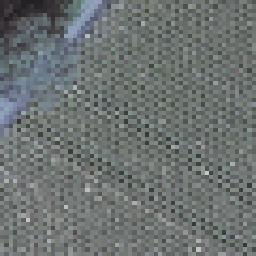

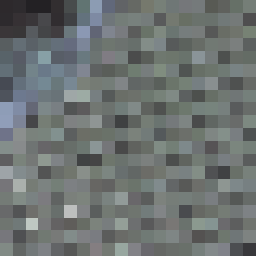

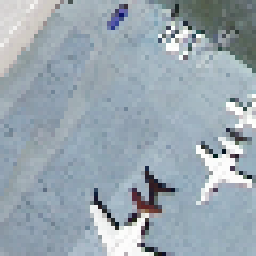

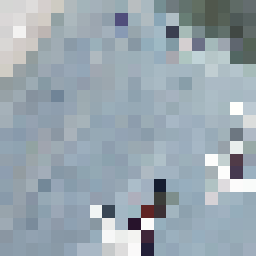

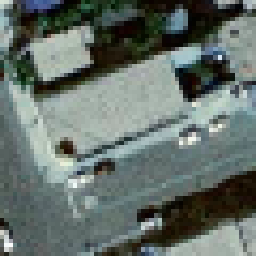

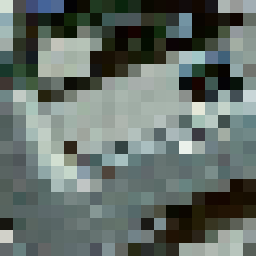

In [118]:
display(Image.fromarray(X_full[0]).resize((256, 256), 0))
display(Image.fromarray(X_lr[0]).resize((256, 256), 0))
display(Image.fromarray(X_full[100]).resize((256, 256), 0))
display(Image.fromarray(X_lr[100]).resize((256, 256), 0))
display(Image.fromarray(X_full[400]).resize((256, 256), 0))
display(Image.fromarray(X_lr[400]).resize((256, 256), 0))

In [119]:
## do super resolution lmao
## import TF stuff
import tensorflow as tf
import tensorflow.keras.layers
import tensorflow.keras.utils as kr_utils
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, MaxPooling2D, Add, BatchNormalization, Dropout, Flatten, Input, InputLayer, Conv2D, ReLU, Concatenate, GlobalAveragePooling2D, LeakyReLU, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import ModelCheckpoint

In [78]:
def make_base_generator():
    seed_size = 100
    batch_size = 64
    #inlayers = [(8, 8, batch_size)]
    
    model = tf.keras.Sequential()
    model.add(Dense(8*8*128, use_bias=False, input_shape=(seed_size,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((8, 8, 128)))
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    print(model.output.shape)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(32, (2, 2), strides=(1, 1), padding='same', use_bias=False))
    print(model.output.shape)
    
    model.add(Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print(model.output.shape)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model
    


In [79]:
make_base_generator()

(None, 8, 8, 64)
(None, 8, 8, 32)
(None, 16, 16, 16)


In [80]:
def edsr_block(x_in, conv_fs):
    #y = x_in
    y = Conv2D(kernel_size=1, filters=conv_fs, strides=1, padding="same", activation="relu")(x_in)
    y = ReLU()(y)
    y = Conv2D(kernel_size=1, filters=conv_fs, strides=1, padding="same")(y)
    y = Add()([x_in, y])
    
    return y

def upsample_block(x_in, factor):
    spl = Lambda(lambda y:tf.nn.depth_to_space(y, block_size=2))
    x = Conv2D(2048 * (factor ** 2), 3, padding="same")(x_in)
    x = spl(x)
    x = Conv2D(2048 * (factor ** 2), 3, padding="same")(x)
    x = spl(x)
    return x

def usb2(x_in, factor):
    usl = Conv2D(16 * (factor ** 2), 3, padding='same')(x_in)
    sfl = Lambda(function=lambda x: tf.nn.depth_to_space(x, factor))(usl)
    usl = Conv2D(16 * (factor ** 2), 3, padding='same')(sfl)
    sfl = Lambda(function=lambda x: tf.nn.depth_to_space(x, factor))(usl)
    return sfl

def make_edsr(in_shape, n_additional_res_blocks):
    spl = Lambda(lambda y:tf.nn.depth_to_space(y, block_size=2))
    sq_in = Input(shape=in_shape)
    sq = Conv2D(kernel_size=(5,5), filters=8, strides=1, padding='same', activation="relu")(sq_in)
    sq1 = edsr_block(sq, 8)
    for i in range(n_additional_res_blocks):
        sq1 = edsr_block(sq, 8)
    sq2 = Conv2D(kernel_size=(3,3), filters=8, strides=1,padding='same', activation="relu")(sq1)
    sq3 = Add()([sq, sq2])
    sq4a= usb2(sq3, 2)
    sq5 = Conv2D(kernel_size=(3,3), filters=3, strides=1,padding='same', activation="relu")(sq4a)
    model = Model(sq_in, sq5)
    return model
    
    
    

In [81]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

In [82]:
edsr_ish = make_edsr((16, 16, 3), 3)
edsr_ish.compile(loss="mae", metrics=[PSNR])
print(edsr_ish.summary())

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 conv2d_210 (Conv2D)            (None, 16, 16, 8)    608         ['input_18[0][0]']               
                                                                                                  
 conv2d_217 (Conv2D)            (None, 16, 16, 8)    72          ['conv2d_210[0][0]']             
                                                                                                  
 re_lu_71 (ReLU)                (None, 16, 16, 8)    0           ['conv2d_217[0][0]']             
                                                                                           

In [92]:
edsr_ish.fit(x = np.array(X_lr[:-25]), y = np.array(X_full[:-25]), epochs=100)

Epoch 1/100
65/65 [==============================] - 5s 56ms/step - loss: 56.5562 - PSNR: 11.2342
Epoch 2/100
65/65 [==============================] - 4s 55ms/step - loss: 37.2400 - PSNR: 15.6558
Epoch 3/100
65/65 [==============================] - 4s 54ms/step - loss: 32.9347 - PSNR: 15.3114
Epoch 4/100
65/65 [==============================] - 4s 54ms/step - loss: 30.8851 - PSNR: 16.8038
Epoch 5/100
65/65 [==============================] - 4s 55ms/step - loss: 29.5862 - PSNR: 16.8632
Epoch 6/100
65/65 [==============================] - 4s 55ms/step - loss: 28.7259 - PSNR: 17.4530
Epoch 7/100
65/65 [==============================] - 4s 55ms/step - loss: 28.0137 - PSNR: 17.9292
Epoch 8/100
65/65 [==============================] - 4s 55ms/step - loss: 27.5373 - PSNR: 17.0058
Epoch 9/100
65/65 [==============================] - 4s 54ms/step - loss: 27.1863 - PSNR: 17.4688
Epoch 10/100
65/65 [==============================] - 4s 55ms/step - loss: 26.8955 - PSNR: 16.8468
Epoch 11/100
65/65 

65/65 [==============================] - 4s 61ms/step - loss: 23.2206 - PSNR: 18.4565
Epoch 84/100
65/65 [==============================] - 4s 58ms/step - loss: 23.1973 - PSNR: 18.5040
Epoch 85/100
65/65 [==============================] - 4s 60ms/step - loss: 23.2460 - PSNR: 18.7147
Epoch 86/100
65/65 [==============================] - 4s 61ms/step - loss: 23.1462 - PSNR: 18.9084
Epoch 87/100
65/65 [==============================] - 4s 61ms/step - loss: 23.1512 - PSNR: 17.3773
Epoch 88/100
65/65 [==============================] - 4s 59ms/step - loss: 23.1624 - PSNR: 18.8096
Epoch 89/100
65/65 [==============================] - 4s 58ms/step - loss: 23.1246 - PSNR: 18.5393
Epoch 90/100
65/65 [==============================] - 4s 58ms/step - loss: 23.1254 - PSNR: 18.2836
Epoch 91/100
65/65 [==============================] - 4s 59ms/step - loss: 23.0435 - PSNR: 17.9003
Epoch 92/100
65/65 [==============================] - 4s 63ms/step - loss: 23.0658 - PSNR: 18.9949
Epoch 93/100
65/65 [===

In [110]:
#predict
predictions = []
for i in range(25):
    predictions.append(np.array(edsr_ish(np.array(X_lr)[[-25+i]]))[0].astype(np.uint8)) 

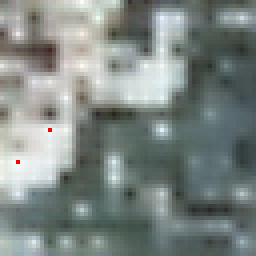

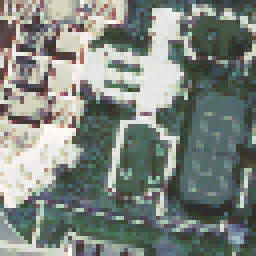

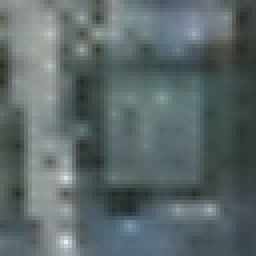

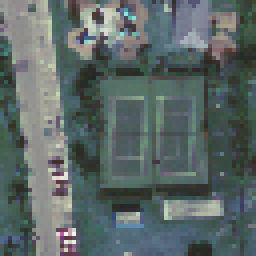

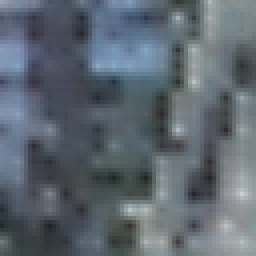

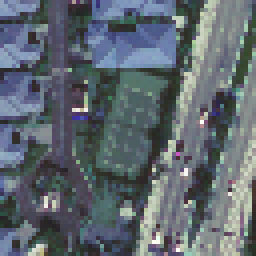

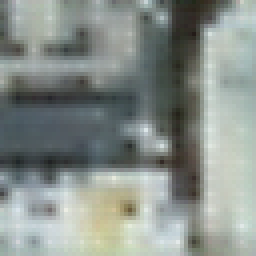

In [114]:
print()
display(Image.fromarray(predictions[0]).resize((256, 256), 0))
display(Image.fromarray(X_full[-25]).resize((256, 256), 0))
display(Image.fromarray(predictions[1]).resize((256, 256), 0))
display(Image.fromarray(X_full[-24]).resize((256, 256), 0))
display(Image.fromarray(predictions[2]).resize((256, 256), 0)) 
display(Image.fromarray(X_full[-23]).resize((256, 256), 0))
display(Image.fromarray(predictions[3]).resize((256, 256), 0)) 

In [ ]:
class offset_net():
    def __init__(network):
        self.net = network
        

In [26]:
class cycle_super_res():
    def __init__ (imgsize, ratio=2, mode="s"):
        self.imgsize = imgsize
        self.ratio=ratio
        self.loss_names = ['cycle']
        self.trainmode = mode
        self.offset_gen_net = 
        

SyntaxError: invalid syntax (3389499989.py, line 7)

NameError: name 'layers' is not defined